# Treinar uma RNN para predizer uma melodia

In [ ]:
!pip install mitdeeplearning music21

In [47]:
import mitdeeplearning.lab1 as mit
import os
from IPython import display as ipythondisplay
import numpy as np
from tensorflow import keras
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import regex as re
import music21
import pickle
from random import randrange
from tqdm.notebook import tqdm_notebook

---
<h1> Criar uma etapa de pré-processamento onde os cabeçalhos do arquivos .abc serão desprezados</h1>

---

## 1 Carregando o dataset

In [2]:
songs = mit.load_training_data()

Found 817 songs in text


In [3]:
songs[0]

"X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\nL:1/8\nK:D Major\n(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!\ndAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!\nAG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!\nFAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!"

In [4]:
def read_audio(audio, name):
    mit.save_song_to_abc(audio, name)
    
    abc = music21.converter.parse(name+'.abc')
    
    abc.write('midi', fp=name+'.midi')
    
    midi = music21.converter.parse(name+'.midi')
    
    midi.show('midi')

In [5]:
read_audio(songs[0],'test')

## 2 Pré processamento

In [6]:
[print(songs[i]+'\n\n\n') for i in range(5)]

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!



X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!



X:3
T:Belfast
Z: id:dc-hornpipe-3
M:C|
L:1/8
K:D Major
ag|(3faf df AdFA|DFAd f2ef|gbec dfAF|GABG E2ag|!
(3faf df AdFA|DFAd f2ef|gbed cABc|d2f2 d2:|!
(3DEF|GFGA Bcde|fgfe dcdB|A2f2 fef2|G2e2 ede2|!
GFGA Bcde|fgfe dcdB|Afed cABc|d2f2 d2:|!
ag|(3fgf (3efe (3ded (3cdc|(3BcB (3ABA G2ba|(3gag (3fgf (3efe (3ded|(3cdc (3BcB A2ag|!
(3fgf (3efe (3ded (3cdc|(3BcB (3ABA (3GAG (3FGF|Eged cABc|d2f2 d2:|!



X:4
T:Blackbird
Z: id:dc-hornpipe-4
M:C|
L:1/8
K:D Mixolydian
AG|F2FA GFD2|de (3fed d^cAF|G2GF 

[None, None, None, None, None]

In [7]:
def removerHeader(song):
    abc = song.split('\n')
    
    abc2 = abc[6:] #remover as 6 linhas do header
    
    abc3 = '\n'.join(abc2)
    
    return abc3

In [8]:
def run(musics,array):  
    for music  in tqdm_notebook(musics):
        newMusic = removerHeader(music)
        array.append(newMusic)

In [9]:
print(songs[12])

X:13
T:Cronin's
Z: id:dc-hornpipe-12
M:C|
L:1/8
K:G Major
BA|GABc d^cdf|gage dega|bage dBGB|BAAG AcBA|!
GABc d^cdf|gage dega|bage dBAB|G2GF G2:|!
fg|add^c d2ga|bee^d e2ga|bgaf gedB|BAAG AcBA|!
GABc d^cdf|gage dega|bage dBAB|G2GF G2:|!


In [10]:
removerHeader(songs[12])

'BA|GABc d^cdf|gage dega|bage dBGB|BAAG AcBA|!\nGABc d^cdf|gage dega|bage dBAB|G2GF G2:|!\nfg|add^c d2ga|bee^d e2ga|bgaf gedB|BAAG AcBA|!\nGABc d^cdf|gage dega|bage dBAB|G2GF G2:|!'

In [11]:
songs_processed = []

In [12]:
run(songs, songs_processed)

  0%|          | 0/817 [00:00<?, ?it/s]

## 3 Criando o vocabulário e dicionário

In [117]:
songs_joined = "\n\n".join(songs_processed) 
def build_vocab(songs):
    vocab = sorted(set(songs_joined))
    return vocab

In [14]:
print(len(songs_joined))

149405


In [15]:
vocab = build_vocab(songs_processed)

In [16]:
print(vocab)

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '/', '1', '2', '3', '4', '6', '8', '9', ':', '<', '=', '>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'K', 'M', 'R', 'V', '[', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'x', 'y', 'z', '|']


In [17]:
def build_dictionary(vocab):
    idx2char = []
    for c in vocab :
        if c not in idx2char : idx2char.append(c)
    char2idx = {w: i for i, w in enumerate(idx2char)} 
    return idx2char, char2idx

In [18]:
idx2char, char2idx = build_dictionary(vocab)

In [141]:
idx2char

['\n',
 ' ',
 '!',
 '"',
 "'",
 '(',
 ')',
 ',',
 '-',
 '/',
 '1',
 '2',
 '3',
 '4',
 '6',
 '8',
 '9',
 ':',
 '<',
 '=',
 '>',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'K',
 'M',
 'R',
 'V',
 '[',
 ']',
 '^',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'i',
 'j',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'x',
 'y',
 'z',
 '|']

In [140]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 '(': 5,
 ')': 6,
 ',': 7,
 '-': 8,
 '/': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '6': 14,
 '8': 15,
 '9': 16,
 ':': 17,
 '<': 18,
 '=': 19,
 '>': 20,
 'A': 21,
 'B': 22,
 'C': 23,
 'D': 24,
 'E': 25,
 'F': 26,
 'G': 27,
 'K': 28,
 'M': 29,
 'R': 30,
 'V': 31,
 '[': 32,
 ']': 33,
 '^': 34,
 '_': 35,
 'a': 36,
 'b': 37,
 'c': 38,
 'd': 39,
 'e': 40,
 'f': 41,
 'g': 42,
 'i': 43,
 'j': 44,
 'l': 45,
 'm': 46,
 'n': 47,
 'o': 48,
 'p': 49,
 'r': 50,
 's': 51,
 't': 52,
 'u': 53,
 'x': 54,
 'y': 55,
 'z': 56,
 '|': 57}

In [19]:
pickle.dump(idx2char, open('idx2char.pickle','wb'))
pickle.dump(char2idx, open('char2idx.pickle','wb'))

In [118]:
def vectorize_string(songs_joined):
    vectorized = [char2idx[c] for c in songs_joined] 
    vectorized = np.array(vectorized, dtype='i')     
    return vectorized

In [119]:
vectorized_songs = vectorize_string(songs_joined)

In [83]:
len(vectorized_songs)

149405

In [22]:
print(repr(songs_joined[:15]), vectorized_songs[:15])

'(3ABc|dAFA DFAd' [ 5 12 21 22 38 57 39 21 26 21  1 24 26 21 39]


In [23]:
idx2char[40]

'e'

## 4 Divisão Treino/Validação

In [24]:
## texto Hello e tamanho da sequência = 4: in:Hell e out:ello
def get_batch(vectorized_songs, seq_length, batch_size):
    
    # captura o tamanho do dataset vetorizado: 200679
    n = vectorized_songs.shape[0] - 1

    # escolhe aleatoriamente os índices iniciais da sentenças
    idx = np.random.choice(n-seq_length, batch_size)

    input_batch = [[vectorized_songs[i:i+seq_length] for i in idx]]
    output_batch = [[vectorized_songs[i+1: i+1+seq_length] for i in idx]]

    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
        
    return x_batch, y_batch

In [25]:
batch_size = 4000  
seq_length = 50  

x_batch, y_batch = get_batch(vectorized_songs, seq_length=seq_length, batch_size=batch_size)
x_train, y_train = x_batch[:3600], y_batch[:3600]
x_valid, y_valid = x_batch[3600:-1], y_batch[3600:-1]

In [26]:
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

(3600, 50) (3600, 50) (399, 50) (399, 50)


## 5 Treinando a RNN 

In [28]:
def create_model(vocab_size, embedding_dim, rnn_units):
    # definindo a arquitetura do modelo    
    model = keras.models.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim), 
        keras.layers.LSTM(rnn_units, recurrent_initializer='glorot_uniform', recurrent_activation='sigmoid', return_sequences=True),
        keras.layers.Dense(units=vocab_size,activation='softmax')
    ])

    return model

In [29]:
def train_model(model, x_train, y_train, x_valid, y_valid):
        
    # Compilando e treinando o modelo
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),metrics=['accuracy']
    )
    
    checkpoint_filepath = './lstm_best_model'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    
    history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), callbacks=[model_checkpoint_callback])
    
    return model, history

In [34]:
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024 
model = create_model(vocab_size, embedding_dim, rnn_units)

Epoch 1/20
113/113 [==============================] - 45s 387ms/step - loss: 2.3499 - accuracy: 0.2616 - val_loss: 1.7258 - val_accuracy: 0.4258
Epoch 2/20
113/113 [==============================] - 44s 386ms/step - loss: 1.5677 - accuracy: 0.4698 - val_loss: 1.4651 - val_accuracy: 0.5053
Epoch 3/20
113/113 [==============================] - 44s 388ms/step - loss: 1.3868 - accuracy: 0.5284 - val_loss: 1.3359 - val_accuracy: 0.5477
Epoch 4/20
113/113 [==============================] - 44s 388ms/step - loss: 1.2656 - accuracy: 0.5707 - val_loss: 1.2556 - val_accuracy: 0.5717
Epoch 5/20
113/113 [==============================] - 44s 388ms/step - loss: 1.1803 - accuracy: 0.5972 - val_loss: 1.1994 - val_accuracy: 0.5911
Epoch 6/20
113/113 [==============================] - 44s 389ms/step - loss: 1.1007 - accuracy: 0.6249 - val_loss: 1.1409 - val_accuracy: 0.6129
Epoch 7/20
113/113 [==============================] - 44s 389ms/step - loss: 1.0229 - accuracy: 0.6515 - val_loss: 1.1028 - val_ac

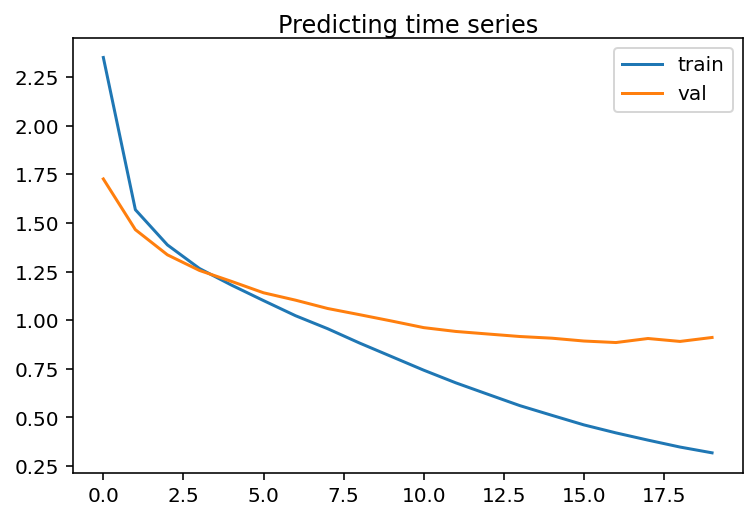

In [328]:
model, history = train_model(model, x_train,y_train,x_valid,y_valid)

# plotando as curvas de aprendizado
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Predicting time series', pad=-80)
plt.legend()
plt.show()

## 6 Predizendo a música

In [35]:
model.load_weights('lstm_best_model')

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 256)         14848     
                                                                 
 lstm_1 (LSTM)               (None, None, 1024)        5246976   
                                                                 
 dense_1 (Dense)             (None, None, 58)          59450     
                                                                 
Total params: 5,321,274
Trainable params: 5,321,274
Non-trainable params: 0
_________________________________________________________________


In [42]:
header = "X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\nL:1/8\nK:D Major\n"
start_string = 'BA|GABc'
def generate_text(model, start_string, generation_length=170):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []

    for i in range(generation_length):
        predictions = model(input_eval)
        sampled_indices = tf.random.categorical(predictions[0], num_samples=1)[-1,0].numpy()
            
        #Passa a previsão junto com o estado anterior como as próximas entradas do modelo
        input_eval = tf.expand_dims([sampled_indices], 0)
        text_generated.append(idx2char[sampled_indices])
        
    return (header+start_string + ''.join(text_generated))

In [43]:
generated_text = generate_text(model, start_string=start_string, generation_length=170)

In [44]:
print(generated_text)

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
BA|GABcaFf[gmEGo|iV82c ally[8Mi|MsR[x)i^Rygl_4aM]8":Cy3g,de"eC3r<us29ml_^F4C//1V<8K !a
<Am^c/x-rA2geDVEBCVMBB_BM(o]DDm=:e=g
x-iDC]6ACa^e ,:
D4aR)|pizyxr3ueGG6A>d|p'i88-D<F!_
o61


---
<h1> - Variar os parâmetros e arquitetura da rede e comparar as acurácias de treinamento e validação </h1>

---

- Aumentar as amostras de treinamento;
- Variar o tamanho da sequência: [25 -150] 
- Variar as épocas de treinamento
- Variar o número de neurônios da camada LSTM: [1024-2048]
- Aumentar o número de camadas LSTM.
- Add camada de dropout

## 1 Aumento do conjunto de treino

In [94]:
header = ""
start_string_list = ['BA|GABc','GF|DGGB', 'ag|(3faf', 'ed|cAAB']
songs_augmentad = []

In [95]:
start_string_list[randrange(1,5)]

'ed|cAAB'

In [96]:
def augmentation(header, startList, array):
    start = startList[randrange(1,5)]
    for i in tqdm_notebook(range(500)):
        amostra = generate_text(model, start)
        array.append(amostra)

In [97]:
augmentation(header, start_string_list, songs_augmentad)

  0%|          | 0/500 [00:00<?, ?it/s]

In [120]:
len(songs_augmentad)

500

In [99]:
songs_joined_aug = "\n\n".join(songs_augmentad)

In [100]:
vectorized_songs_aug = vectorize_string(songs_joined_aug)

In [101]:
def get_batch(vectorized_songs, seq_length, batch_size):
    
    # captura o tamanho do dataset vetorizado: 200679
    n = vectorized_songs.shape[0] - 1

    # escolhe aleatoriamente os índices iniciais da sentenças
    idx = np.random.choice(n-seq_length, batch_size)

    input_batch = [[vectorized_songs[i:i+seq_length] for i in idx]]
    output_batch = [[vectorized_songs[i+1: i+1+seq_length] for i in idx]]

    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
        
    return x_batch, y_batch

In [130]:
batch_size = 4000
seq_length = 65  

In [131]:
x_batch_aug, y_batch_aug = get_batch(vectorized_songs_aug, seq_length=seq_length, batch_size=batch_size)

In [132]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=seq_length, batch_size=batch_size)
x_train, y_train =np.concatenate((x_batch[:3600],x_batch_aug), axis=0), np.concatenate((y_batch[:3600],y_batch_aug), axis=0)
x_valid, y_valid = x_batch[3600:-1], y_batch[3600:-1]

In [133]:
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

(7600, 65) (7600, 65) (399, 65) (399, 65)


# 2 Alterando a arquitetura

In [134]:
def create_model(vocab_size, embedding_dim, rnn_units):
    # definindo a arquitetura do modelo    
    model = keras.models.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim), 
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.LSTM(rnn_units, recurrent_initializer='glorot_uniform',dropout=0.3, recurrent_activation='sigmoid', return_sequences=True),
        keras.layers.LSTM(rnn_units, recurrent_initializer='glorot_uniform',dropout=0.3, recurrent_activation='sigmoid', return_sequences=True),
        keras.layers.Dense(units=vocab_size,activation='softmax'),
        keras.layers.Dropout(0.3)
#         keras.layers.LSTM(rnn_units, recurrent_initializer='glorot_uniform', recurrent_activation='sigmoid', return_sequences=True),
#         keras.layers.Dense(units=vocab_size,activation='softmax'),
#         keras.layers.Dropout(0.5)
    ])

    return model

In [135]:
def train_model(model, x_train, y_train, x_valid, y_valid):
        
    # Compilando e treinando o modelo
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),metrics=['accuracy']
    )
    
    checkpoint_filepath = './lstm_best_model_v2'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    
    history = model.fit(x_train, y_train, epochs=25, validation_data=(x_valid, y_valid), callbacks=[model_checkpoint_callback])
    
    return model, history

Epoch 1/25
238/238 [==============================] - 347s 1s/step - loss: 7.2583 - accuracy: 0.0552 - val_loss: 3.0953 - val_accuracy: 0.1036
Epoch 2/25
238/238 [==============================] - 344s 1s/step - loss: 6.8936 - accuracy: 0.0977 - val_loss: 2.3194 - val_accuracy: 0.3222
Epoch 3/25
238/238 [==============================] - 345s 1s/step - loss: 6.3782 - accuracy: 0.1592 - val_loss: 1.9217 - val_accuracy: 0.3961
Epoch 4/25
238/238 [==============================] - 343s 1s/step - loss: 6.1961 - accuracy: 0.1843 - val_loss: 1.7324 - val_accuracy: 0.4444
Epoch 5/25
238/238 [==============================] - 342s 1s/step - loss: 6.1370 - accuracy: 0.1974 - val_loss: 1.6387 - val_accuracy: 0.4758
Epoch 6/25
238/238 [==============================] - 340s 1s/step - loss: 6.1044 - accuracy: 0.2047 - val_loss: 1.6130 - val_accuracy: 0.4918
Epoch 7/25
238/238 [==============================] - 341s 1s/step - loss: 6.0650 - accuracy: 0.2127 - val_loss: 1.5743 - val_accuracy: 0.5158

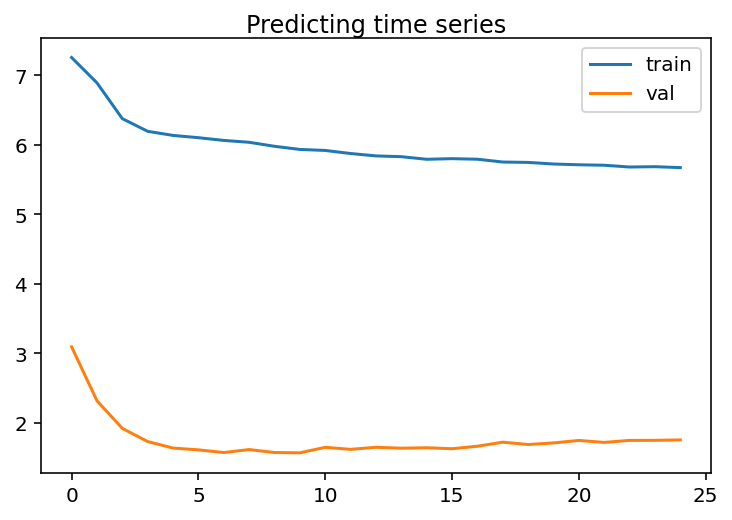

In [136]:
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1400 

model = create_model(vocab_size, embedding_dim, rnn_units)
model, history = train_model(model, x_train,y_train,x_valid,y_valid)

# plotando as curvas de aprendizado
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Predicting time series', pad=-80)
plt.legend()
plt.show()

In [137]:
header = "X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\nL:1/8\nK:D Major\n"
start_string = 'BA|GABc'
def generate_text(model, start_string, generation_length=170):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []

    for i in range(generation_length):
        predictions = model(input_eval)
        sampled_indices = tf.random.categorical(predictions[0], num_samples=1)[-1,0].numpy()
            
        #Passa a previsão junto com o estado anterior como as próximas entradas do modelo
        input_eval = tf.expand_dims([sampled_indices], 0)
        text_generated.append(idx2char[sampled_indices])
        
    return (header+start_string + ''.join(text_generated))

In [138]:
generated_text = generate_text(model, start_string=start_string, generation_length=170)

In [139]:
print(generated_text)

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
BA|GABc ,/r|cetxe2'm_'GpBf()y o3mV^V^!s"orApsDca3"-1y -6px!Bp1B'As6B"V/4-'
lexa4j"__p>e_z!oAyu^9)"p!dr8C">Mi4DzA^K- FiGt_1Gt|'(cbx8V,,/G
mieiDBM
uo4 ]f8m!gr,3o)e>
g/aaF6xd"|a=="
